In [25]:
!pip install torch torchvision ftfy regex tqdm transformers diffusers
!pip install git+https://github.com/openai/CLIP.git
!git clone https://github.com/salesforce/BLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-mji6s8zs
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-mji6s8zs
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
fatal: destination path 'BLIP' already exists and is not an empty directory.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

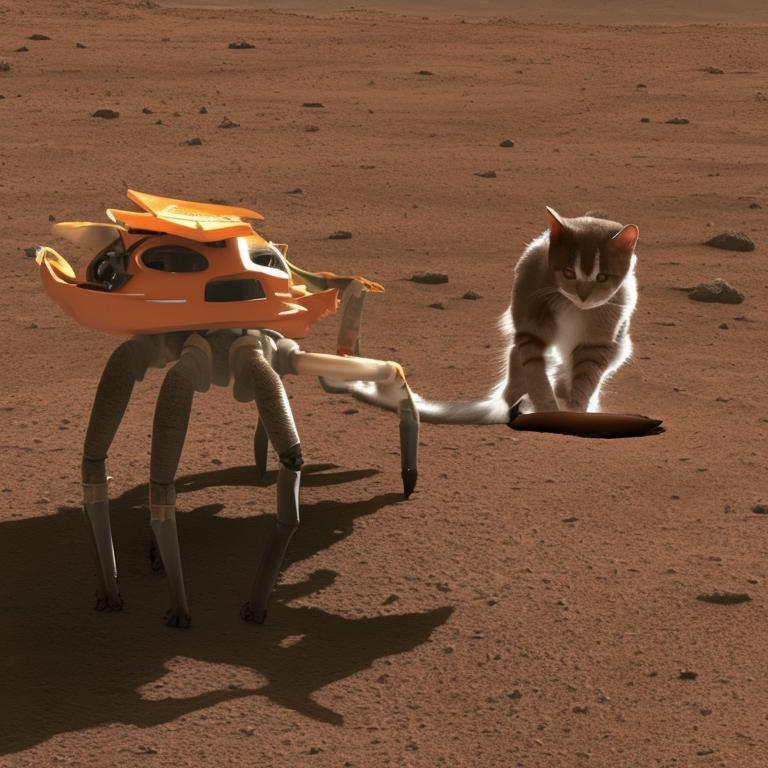

In [26]:
import torch
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler

# Load the model
model_id = "stabilityai/stable-diffusion-2"
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder = "scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16).to("cuda")
pipe = pipe.to("cuda")

# Generate an image from a prompt
prompt = "a photo of a cat riding a crab on mars"
image = pipe(prompt).images[0]
image.save("generated_image.jpg")

# Display the image
from IPython.display import Image as IPImage

IPImage("generated_image.jpg")

In [27]:
import clip
from PIL import Image
import torch

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load our generated image
image = Image.open("generated_image.jpg")
image_input = preprocess(image).unsqueeze(0).to(device)

# Create text descriptions to test
text_descriptions = [
    "a photo of an astronaut riding a horse on mars",
    "a photo of a cat riding a crab on mars",
    "a digital painting of a space explorer",
    "a picture of Kannada actor Darshan arm wrestling with Sai Kumar"
]
text_tokens = clip.tokenize(text_descriptions).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_tokens)

    # Normalize the features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Calculate similarity
    similarity = (100 * image_features @ text_features.T).softmax(dim=-1)

# Print results
for i, description in enumerate(text_descriptions):
    print(f"{description}: {similarity[0][i].item():.2%}")

a photo of an astronaut riding a horse on mars: 2.37%
a photo of a cat riding a crab on mars: 97.61%
a digital painting of a space explorer: 0.00%
a picture of Kannada actor Darshan arm wrestling with Sai Kumar: 0.00%


In [31]:
from transformers import BlipProcessor, BlipForQuestionAnswering

# Load BLIP VQA model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# Load the image
image = Image.open("generated_image.jpg")

# Define questions
questions = [
    "Does this image have any animal? If yes, what?",
    "Where is this scene taking place?",
    "Which animal is seen in the image?"
]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


for question in questions:
    inputs = processor(image, question, return_tensors="pt").to(device)
    out = model.generate(**inputs)
    print(f"Q: {question}")
    print(f"A: {processor.decode(out[0], skip_special_tokens=True)}")
    print()

Q: Does this image have any animal? If yes, what?
A: yes

Q: Where is this scene taking place?
A: desert

Q: Which animal is seen in the image?
A: cat

